#Multiclass Classification

# Team : **The Mean Squares**
by **Subarna Chowdhury Soma** [SJSU ID: 014549587]

# Imports

In [0]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import argparse
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import nltk as nl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import ParameterGrid
import statistics
import random
import string
import warnings
from gensim.models import word2vec
from string import punctuation
from matplotlib import pyplot
from nltk.stem.porter import PorterStemmer
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
import nltk
import re
import io
import requests
import time
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import nltk.sentiment


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from scipy import sparse
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from Chakraborty et al. (https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

change location here

In [0]:
location = "/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/liar_dataset/"
location1= "/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/"

# Loading Dataset

## Kaggle- Fake News

In [0]:
def get_parsed_data(url, sep='\t', header=None ):
  return pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')), sep=sep, header=header )

# Download and parse the dataset... Let us first work with 100 articles
KAGGLE_DATASET = 'https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle'
fake_news_data = get_parsed_data('%s/kaggle-fake.csv'% KAGGLE_DATASET, ',' , 'infer' )

In [0]:
fake_news_data.head(3)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias


## Liar Liar Dataset

In [0]:
colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 
            'speakerjobtitle', 'stateinfo','partyaffiliation', 
            'barelytruecounts', 'falsecounts','halftruecounts',
            'mostlytrueocounts','pantsonfirecounts','context']
headlinecolname = 'headline_text'
labelcolname = 'encoded_label'
processedheadlinecolname = 'processed_headline_text'

###important columns: label,headline_text,processed_headline_text,encoded_label

In [0]:
#method to load data
colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytrueocunts','pantsonfirecounts','context']
def load_train_data():
    #load data
    train_filename = location +'train.tsv'
    train_news = pd.read_csv(train_filename, sep='\t', names = colnames,error_bad_lines=False)
    return train_news

def load_test_data():
    test_filename = location+'test.tsv'
    test_news = pd.read_csv(test_filename, sep='\t', names = colnames,error_bad_lines=False)
    return test_news

def load_valid_data():
    test_filename = location+'valid.tsv'
    test_news = pd.read_csv(test_filename, sep='\t', names = colnames,error_bad_lines=False)
    return test_news

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(fake_news_data, y, test_size=0.2)

# Preprocessing

## Kaggle Fake News

In [0]:
model = gensim.models.KeyedVectors.load_word2vec_format(location1+'GoogleNews-vectors-negative300.bin.gz', binary=True)
words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

### Spell Cheaker

In [0]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [0]:
def spell_checker(text):
    all_words = re.findall(r'\w+', text.lower()) # split sentence to words
    spell_checked_text  = []
    for i in range(len(all_words)):
        spell_checked_text.append(correction(all_words[i]))
    return ' '.join(spell_checked_text)

In [0]:
fake_news_data['type'].value_counts()

bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: type, dtype: int64

## Liar Liar Dataset

#### Label Encoding


* true           1676
* mostly-true    1962
* half-true      2114
* barely-true    1654
* false          1995
* pants-fire      839

In [0]:
#label encoding
true_labels = ['original','true','mostly-true','half-true']
false_labels = ['barely-true','false','pants-fire']

def encode_news_type(input_label):
    if input_label == 'true':
        return 1
    elif input_label == 'mostly-true':
        return 2
    elif input_label == 'half-true':
        return 3
    elif input_label == 'barely-true':
        return 4
    elif input_label == 'false':
        return 5
    elif input_label == 'pants-fire':
        return 6

#### Remove Punctuations

In [0]:
#method to remove punctuations from textual data
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

#### Remove Stopwords

In [0]:
from nltk.stem.snowball import SnowballStemmer
sw = stopwords.words('english')
stemmer = SnowballStemmer("english")

#Remove stop words
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

#Lemmetize and pos tagging
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

#Stemming
def stemming(text):    
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

#### Distillation on Test and Training Data

In [0]:
def text_preprocess(df):
  ## headline_text
    #encode labels
    df['encoded_label'] = df.apply(lambda row: encode_news_type(row['label']), axis=1)
    #convert to lower case
    df['processed_headline_text'] = df['headline_text'].str.lower()
    #remove stop words
    df['processed_headline_text'] = df['processed_headline_text'].apply(remove_stopwords)
    #spell check
    df['processed_headline_text'] = df['processed_headline_text'].apply(spell_checker)
    #Lemmetize
    df['processed_headline_text'] = df['processed_headline_text'].apply(lemmatize_stemming)
    #stemming
    df['processed_headline_text'] = df['processed_headline_text'].apply(stemming)
    #remove punctuation
    df['processed_headline_text'] = df['processed_headline_text'].apply(remove_punctuation)
    #remove less than 3 letter words
    df['processed_headline_text']  = df.processed_headline_text.apply(lambda i: ' '.join(filter(lambda j: len(j) > 3, i.split())))
    return df[['headline_text','processed_headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo', 'partyaffiliation', 'context', 'encoded_label']]

##### Call Load Data Function

In [0]:
#load test and train data
train_news = load_train_data()
test_news = load_test_data()
valid_news = load_valid_data()

##### Call Preprocessing Function

In [0]:
#pre-processing train dataset
df_train = text_preprocess(train_news)
df_train.head(5)

,headline_text,processed_headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label
0,Says the Annies List political group supports ...,nanni list polit group support third trimest a...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,5
1,When did the decline of coal start? It started...,declin coal start start natur took start begin...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,3
2,"Hillary Clinton agrees with John McCain ""by vo...",hillari clinton agre john mccain vote give geo...,foreign-policy,barack-obama,President,Illinois,democrat,Denver,2
3,Health care reform legislation is likely to ma...,health care reform legisl like mandat free cha...,health-care,blog-posting,NaN,NaN,none,a news release,5
4,The economic turnaround started at the end of ...,econom turnaround start term,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN,3


In [0]:
#pre-processing test dataset
df_test = text_preprocess(test_news)
df_test.head(5)

,headline_text,processed_headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label
0,Building a wall on the U.S.-Mexico border will...,build wall mexico border take liter year,immigration,rick-perry,Governor,Texas,republican,Radio interview,1
1,Wisconsin is on pace to double the number of l...,wisconsin pace doubl number layoff year,jobs,katrina-shankland,State representative,Wisconsin,democrat,a news conference,5
2,Says John McCain has done nothing to help the ...,john mccain done noth help,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,comments on ABC's This Week.,5
3,Suzanne Bonamici supports a plan that will cut...,suzann bonamici support plan choic medicar adv...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,a radio show,3
4,When asked by a reporter whether hes at the ce...,report whether center crimin scheme violat cam...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,a web video,6


In [0]:
#pre-processing valid dataset
df_valid = text_preprocess(valid_news)
df_valid.head(5)

,headline_text,processed_headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label
0,We have less Americans working now than in the...,less american work,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,an interview with ABC17 News,4
1,"When Obama was sworn into office, he DID NOT u...",obama sworn offic holi bibl instead kura their...,"obama-birth-certificate,religion",chain-email,NaN,NaN,none,NaN,6
2,Says Having organizations parading as being so...,organ parad social welfar organ involv polit c...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,a U.S. Ways and Means hearing,5
3,Says nearly half of Oregons children are poor.,near half oregon children poor,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,an opinion article,3
4,On attacks by Republicans that various program...,attack republican various program econom stimu...,"economy,stimulus",barack-obama,President,Illinois,democrat,interview with CBS News,3


In [0]:
train_news['index'] = train_news.index

train_news.head()

test_news['index'] = test_news.index

test_news.head()

valid_news['index'] = valid_news.index

valid_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,encoded_label,processed_headline_text,index
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,4,less american work,0
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN,6,obama sworn offic holi bibl instead kura their...,1
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,5,organ parad social welfar organ involv polit c...,2
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,3,near half oregon children poor,3
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,3,attack republican various program econom stimu...,4


In [0]:

train_news.to_csv(location+"train_cleantext.csv", sep=',')
test_news.to_csv(location+"test_cleantext.csv", sep=',')
valid_news.to_csv(location+"valid_cleantext.csv", sep=',')

# Visualizations

## Liar Liar Dataset

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [0]:
#text length matrix
def word_length_visualisation(df):
    text_len = []

    for i in range(len(df.headline_text)):
        text_len.append(len(str(df.headline_text[i])))
    plt.figure(figsize=(10,6))
    pd.DataFrame(text_len).hist(bins = 100)

Train Data Word Length Visualization


<Figure size 720x432 with 0 Axes>

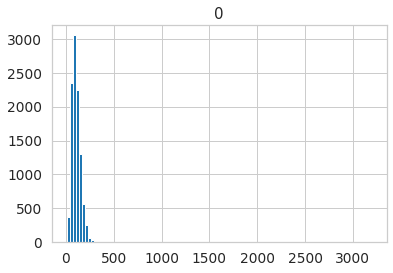

In [0]:
print('Train Data Word Length Visualization')
word_length_visualisation(df_train)

Test Data Word Length Visualization


<Figure size 720x432 with 0 Axes>

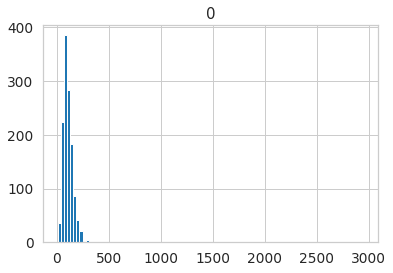

In [0]:
print('Test Data Word Length Visualization')
word_length_visualisation(df_test)

In [0]:
def fake_news_distribution(df):
    #Training data set with text, domain ranking and type.
    X = df[['processed_headline_text', 'encoded_label']]

    plt.title('Category Vs Count')
    X.groupby(['encoded_label']).size().plot(kind='barh', color='blue')
    plt.xlabel('count')
    plt.show()

Train Data Fake News Encoded Label Visualization


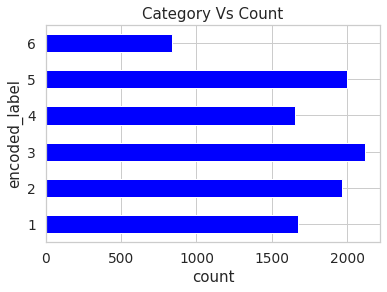

Test Data Fake News Encoded Label  Visualization


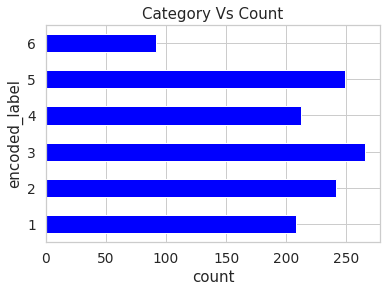

In [0]:

print('Train Data Fake News Encoded Label Visualization')
fake_news_distribution(df_train)

print('Test Data Fake News Encoded Label  Visualization')
fake_news_distribution(df_test)

#### Row counts by Label


Row counts by Label:
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64


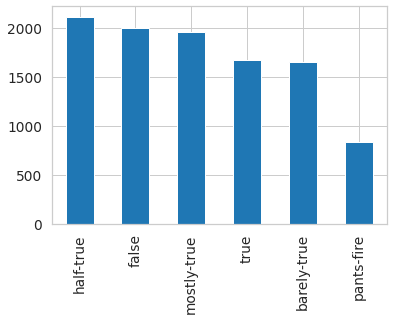

In [0]:
print("\nRow counts by Label:")
s= train_news['label'].value_counts()
print(s)
s.plot(kind='bar')


Row counts by Label:
half-true      265
false          249
mostly-true    241
barely-true    212
true           208
pants-fire      92
Name: label, dtype: int64


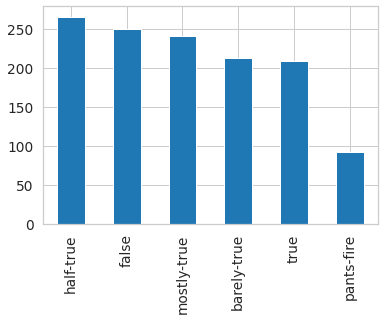

In [0]:
print("\nRow counts by Label:")
s= test_news['label'].value_counts()
print(s)
s.plot(kind='bar')

### Word cloud

In [0]:
#Word Cloud to Visualize important text
# lower max_font_size, change the maximum number of word and lighten the background

def word_cloud_visualization(df):
    text = " ".join(ht for ht in df.processed_headline_text)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Train Data Word Cloud Visualization


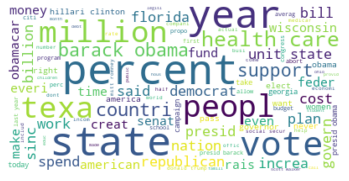

Test Data Word Cloud Visualization


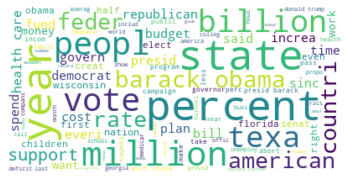

In [0]:
print('Train Data Word Cloud Visualization')
word_cloud_visualization(df_train)

print('Test Data Word Cloud Visualization')
word_cloud_visualization(df_test)

### Word2Vec and t-SNE

In [0]:

num_features = 15      # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

#Create Word2Vec Model. Get Vector from the model
word_tokens = []
for i in range(len(df_train)):
    words = df_train['processed_headline_text'][i].split()
    word_tokens.append(words)
    
word2vec_model = word2vec.Word2Vec(word_tokens, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

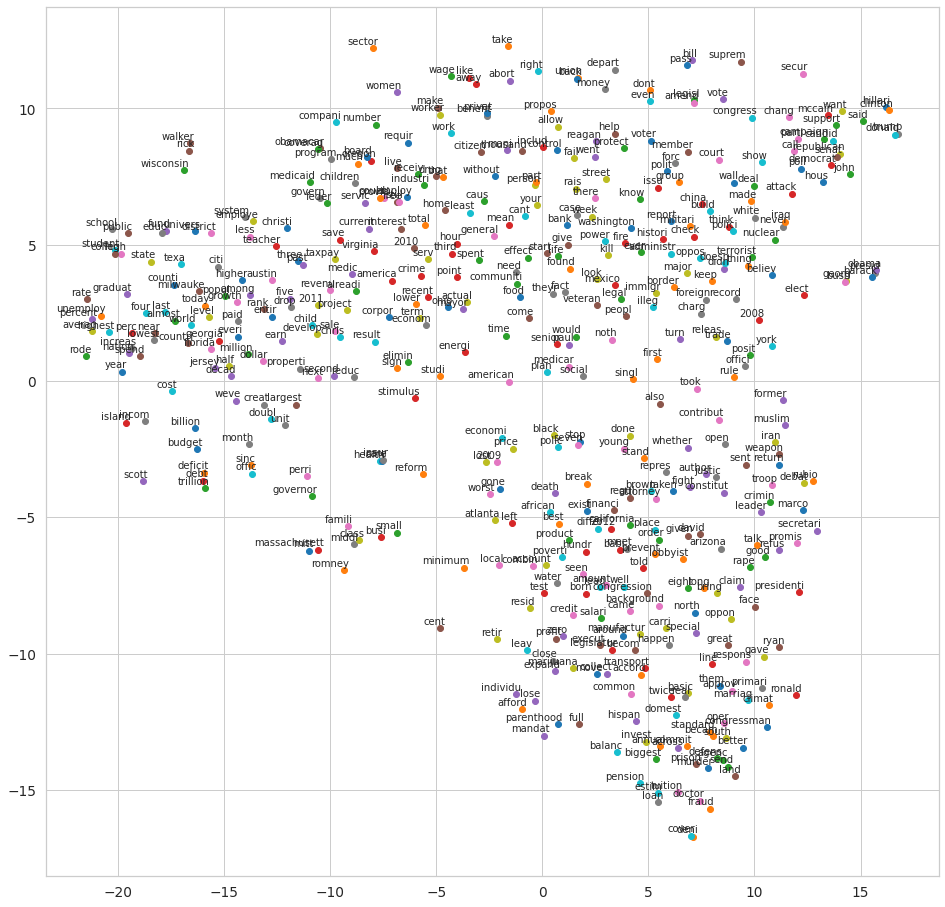

In [0]:
#"Creates and TSNE model and plots it"
from sklearn.manifold import TSNE
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(word2vec_model)

In [0]:
def create_distribution1(dataFile):
    return sb.countplot(x=labelcolname, data=dataFile, palette='hls')

In [0]:
import seaborn as sb
def create_distribution2(dataFile, colname):
    g = sb.countplot(x=colname, data=dataFile, palette='hls')
    g.set_xticklabels(g.get_xticklabels(),rotation=90)

    return g

In [0]:
df_train.head(5)

,headline_text,processed_headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label
0,Says the Annies List political group supports ...,nanni list polit group support third trimest a...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,5
1,When did the decline of coal start? It started...,declin coal start start natur took start begin...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,3
2,"Hillary Clinton agrees with John McCain ""by vo...",hillari clinton agre john mccain vote give geo...,foreign-policy,barack-obama,President,Illinois,democrat,Denver,2
3,Health care reform legislation is likely to ma...,health care reform legisl like mandat free cha...,health-care,blog-posting,NaN,NaN,none,a news release,5
4,The economic turnaround started at the end of ...,econom turnaround start term,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN,3


# LDA Analysis

In [0]:
all_data = pd.concat([df_train, df_test])

In [0]:
df_train, df_test = train_test_split(all_data, test_size=0.2, random_state=0)


In [0]:
df_train.head(3)

,headline_text,processed_headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label
8523,The top 1 percent pay 45 percent of all taxes ...,percent percent countri,taxes,jeb-bush,NaN,Florida,republican,"in a town hall in Concord, New Hampshire",3
9773,Seven of Americas 10 wealthiest counties are i...,seven america wealthiest counti washington area,"deficit,federal-budget",jim-jordan,U.S. representative,Ohio,republican,an interview on Fox News Sunday,1
2081,Portland Community College serves more student...,portland communiti colleg serv student state u...,education,portland-community-college,community college,Oregon,none,the college's website,5


## Doc2Vec modeling

In [0]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20,column='clean_text'):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1
        self.column = column

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row[self.column]).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row[self.column]).split())
                                     for index, row in df_x.iterrows()]))

In [0]:
#doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr = Doc2VecTransformer(vector_size=10, learning_rate=0.001, epochs=10,column='processed_headline_text')
doc2vec_tr.fit(all_data)
doc2vec_vectors = doc2vec_tr.transform(all_data)

100%|██████████| 11507/11507 [00:00<00:00, 1524201.99it/s]


In [0]:
doc2vec_vectors.shape

(11507, 10)

In [0]:
labels = all_data['encoded_label'].values
labels.shape

(11507,)

## Tf-IDF Modeling

In [0]:
tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                           analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,5),
                           use_idf=1, smooth_idf=1, sublinear_tf=1)

X_train_text = tfidf.fit_transform(df_train['processed_headline_text'])
X_test_text  = tfidf.transform(df_test['processed_headline_text'])

In [0]:
X_train_text.shape

(9205, 7116)

['state', 'year', 'percent', 'obama', 'presid', 'vote', 'health', 'million', 'peopl', 'american']


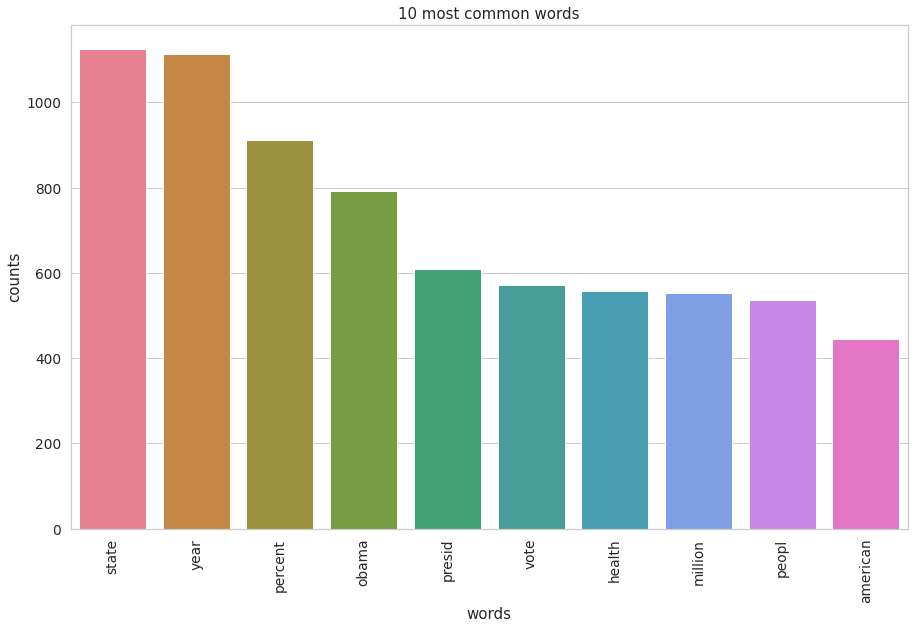

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    print(words)
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_train['processed_headline_text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [0]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
obama presid barack year percent american immigr peopl million state

Topic #1:
clinton hillari said iraq public school romney want percent attack

Topic #2:
health care vote billion fund dollar republican budget feder million

Topic #3:
state percent rate year sinc unemploy countri democrat republican secur

Topic #4:
year state percent peopl spend budget million increas trump texa


In [0]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [0]:
all_data.dtypes

headline_text              object
processed_headline_text    object
subject                    object
speaker                    object
speakerjobtitle            object
stateinfo                  object
partyaffiliation           object
context                    object
encoded_label               int64
dtype: object

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
t1 = time.time()
all_data['tokenized'] = all_data['processed_headline_text'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(all_data), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 11507 articles: 0.06241665681203206 min


In [0]:
all_data.head(2)

,headline_text,processed_headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label,tokenized
0,Says the Annies List political group supports ...,nanni list polit group support third trimest a...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,5,"[nanni, list, polit, group, support, third, tr..."
1,When did the decline of coal start? It started...,declin coal start start natur took start begin...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,3,"[declin, coal, start, start, natur, took, star..."


In [0]:
#merged_data.to_csv('tokenized_data.csv',index=False)

In [0]:
from gensim import models, corpora, similarities
from gensim.models import LdaModel

def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 10
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(all_data), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [0]:
dictionary,corpus,lda = train_lda(all_data)


Time to train LDA model on  11507 articles:  0.08112813234329223 min


In [0]:
len(dictionary)

7196

In [0]:
lda.show_topics(num_topics=10, num_words=20)


[(0,
  '0.062*"health" + 0.055*"care" + 0.023*"would" + 0.023*"educ" + 0.023*"busi" + 0.022*"percent" + 0.020*"secur" + 0.020*"incom" + 0.017*"bill" + 0.017*"fund" + 0.017*"stimulu" + 0.016*"take" + 0.016*"famili" + 0.016*"cost" + 0.015*"could" + 0.015*"social" + 0.015*"oppo" + 0.015*"iraq" + 0.014*"american" + 0.014*"peopl"'),
 (1,
  '0.061*"million" + 0.043*"public" + 0.039*"dollar" + 0.038*"even" + 0.030*"system" + 0.028*"illeg" + 0.028*"immigr" + 0.026*"number" + 0.025*"dont" + 0.025*"want" + 0.023*"without" + 0.022*"know" + 0.021*"spent" + 0.019*"help" + 0.019*"need" + 0.018*"univ" + 0.018*"privat" + 0.017*"would" + 0.017*"administr" + 0.017*"start"'),
 (2,
  '0.078*"percent" + 0.048*"texa" + 0.046*"rate" + 0.024*"unemploy" + 0.024*"averag" + 0.024*"year" + 0.023*"governor" + 0.022*"scott" + 0.022*"state" + 0.021*"medicar" + 0.020*"rick" + 0.020*"today" + 0.019*"live" + 0.018*"perc" + 0.017*"children" + 0.017*"nation" + 0.014*"four" + 0.014*"walker" + 0.013*"alreadi" + 0.012*"coun

In [0]:
#lda.save('/content/drive/My Drive/model2/lda.model')


In [0]:
all_data.loc[all_data.index == 0]

,headline_text,processed_headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label,tokenized
0,Says the Annies List political group supports ...,nanni list polit group support third trimest a...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,5,"[nanni, list, polit, group, support, third, tr..."
0,Building a wall on the U.S.-Mexico border will...,build wall mexico border take liter year,immigration,rick-perry,Governor,Texas,republican,Radio interview,1,"[build, wall, mexico, border, take, liter, year]"


## Add LDA Topics to dataframe 

In [0]:
all_data['lda_topics'] = ''

In [0]:
def getKey(item):
  return item[1]



corpus = [dictionary.doc2bow(doc) for doc in all_data['tokenized']]
for i in range(0,len(corpus)):
  list = lda[corpus[i]] # corpus[0] means the first document.
  sorted_list = sorted(list, key=getKey)
  sorted_list.reverse()
  text = " ".join([dictionary[j[0]] for j in sorted_list])
  
  all_data.loc[all_data.index == i, ['lda_topics']] = text


In [0]:
all_data.head(3)

,headline_text,processed_headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label,tokenized,lda_topics
0,Says the Annies List political group supports ...,nanni list polit group support third trimest a...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,5,"[nanni, list, polit, group, support, third, tr...",trimest support nanni administr third polit li...
1,When did the decline of coal start? It started...,declin coal start start natur took start begin...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,3,"[declin, coal, start, start, natur, took, star...",trimest demand third polit administr support n...
2,"Hillary Clinton agrees with John McCain ""by vo...",hillari clinton agre john mccain vote give geo...,foreign-policy,barack-obama,President,Illinois,democrat,Denver,2,"[hillari, clinton, agr, john, mccain, vote, gi...",polit administr third trimest support nanni li...


## Doc2Vec for LDA topics

In [0]:
#doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vector2 = Doc2VecTransformer(vector_size=10, learning_rate=0.001, epochs=10,column='lda_topics')
doc2vector2.fit(all_data)
doc2vec_vectors2 = doc2vector2.transform(all_data)

100%|██████████| 11507/11507 [00:00<00:00, 1856659.21it/s]


## Sentiment Analysis

In [0]:
all_data['negative'] = 0.0
all_data['neutral'] = 0.0
all_data['positive'] = 0.0
all_data['compound'] = 0.0


In [0]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

headlines = all_data['processed_headline_text'].tolist()
ids = all_data.index.tolist()
for index in range(0,len(headlines)):
    line = headlines[index]
    if not pd.isna(line):
      pol_score = senti.polarity_scores(line)
      #print(pol_score)
      id = ids[index]
      all_data.loc[all_data.index == id, ['negative']] = pol_score['neg']# [neg,neu,pos,compound]
      all_data.loc[all_data.index == id, ['neutral']] = pol_score['neu']
      all_data.loc[all_data.index == id, ['positive']] = pol_score['pos']
      all_data.loc[all_data.index == id, ['compound']] = pol_score['compound']
      if index % 1500 == 0:
        print("processing ",index,' of ',len(headlines))
        
      
all_data.head(2)

processing  0  of  11507
processing  1500  of  11507
processing  3000  of  11507
processing  4500  of  11507
processing  6000  of  11507
processing  7500  of  11507
processing  9000  of  11507
processing  10500  of  11507


,headline_text,processed_headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label,tokenized,lda_topics,negative,neutral,positive,compound
0,Says the Annies List political group supports ...,nanni list polit group support third trimest a...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,5,"[nanni, list, polit, group, support, third, tr...",trimest support nanni administr third polit li...,0.0,1.000,0.000,0.0000
1,When did the decline of coal start? It started...,declin coal start start natur took start begin...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,3,"[declin, coal, start, start, natur, took, star...",trimest demand third polit administr support n...,0.0,0.794,0.206,0.0772


In [0]:
#merged_data.to_csv('sentiment_isot.csv')

In [0]:
sentiment_values = all_data[['compound','negative','neutral','positive']].values
sentiment_values.shape

(11507, 4)

## Taking other Categorical Columns

In [0]:
all_data.head(3)

,headline_text,processed_headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label,tokenized,lda_topics,negative,neutral,positive,compound
0,Says the Annies List political group supports ...,nanni list polit group support third trimest a...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,5,"[nanni, list, polit, group, support, third, tr...",trimest support nanni administr third polit li...,0.0,1.000,0.000,0.0000
1,When did the decline of coal start? It started...,declin coal start start natur took start begin...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,3,"[declin, coal, start, start, natur, took, star...",trimest demand third polit administr support n...,0.0,0.794,0.206,0.0772
2,"Hillary Clinton agrees with John McCain ""by vo...",hillari clinton agre john mccain vote give geo...,foreign-policy,barack-obama,President,Illinois,democrat,Denver,2,"[hillari, clinton, agr, john, mccain, vote, gi...",polit administr third trimest support nanni li...,0.0,0.597,0.403,0.4019


In [0]:
all_data['subject_codes'] = all_data['subject'].astype('category').cat.codes
all_data['speaker_codes'] = all_data['speaker'].astype('category').cat.codes
all_data['partyaffiliation_codes'] = all_data['partyaffiliation'].astype('category').cat.codes
all_data['speakerjobtitle_codes'] = all_data['speakerjobtitle'].astype('category').cat.codes
all_data['context_codes'] = all_data['context'].astype('category').cat.codes

In [0]:
cat_col_values = all_data[['subject_codes','speaker_codes','partyaffiliation_codes','speakerjobtitle_codes','context_codes']].values
cat_col_values.shape

(11507, 5)

## Aggregate vectors and sentiment labels

In [0]:
print(doc2vec_vectors.shape)
print(doc2vec_vectors2.shape)
print(sentiment_values.shape)
doc2vec_vectors3 = np.concatenate([doc2vec_vectors, doc2vec_vectors2,sentiment_values,cat_col_values],axis=1)
print(doc2vec_vectors3.shape)

(11507, 10)
(11507, 10)
(11507, 4)
(11507, 29)


In [0]:
labels = all_data['encoded_label'].values
labels.shape

(11507,)

# Multilevel Classification

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text major ticklabel objects>)

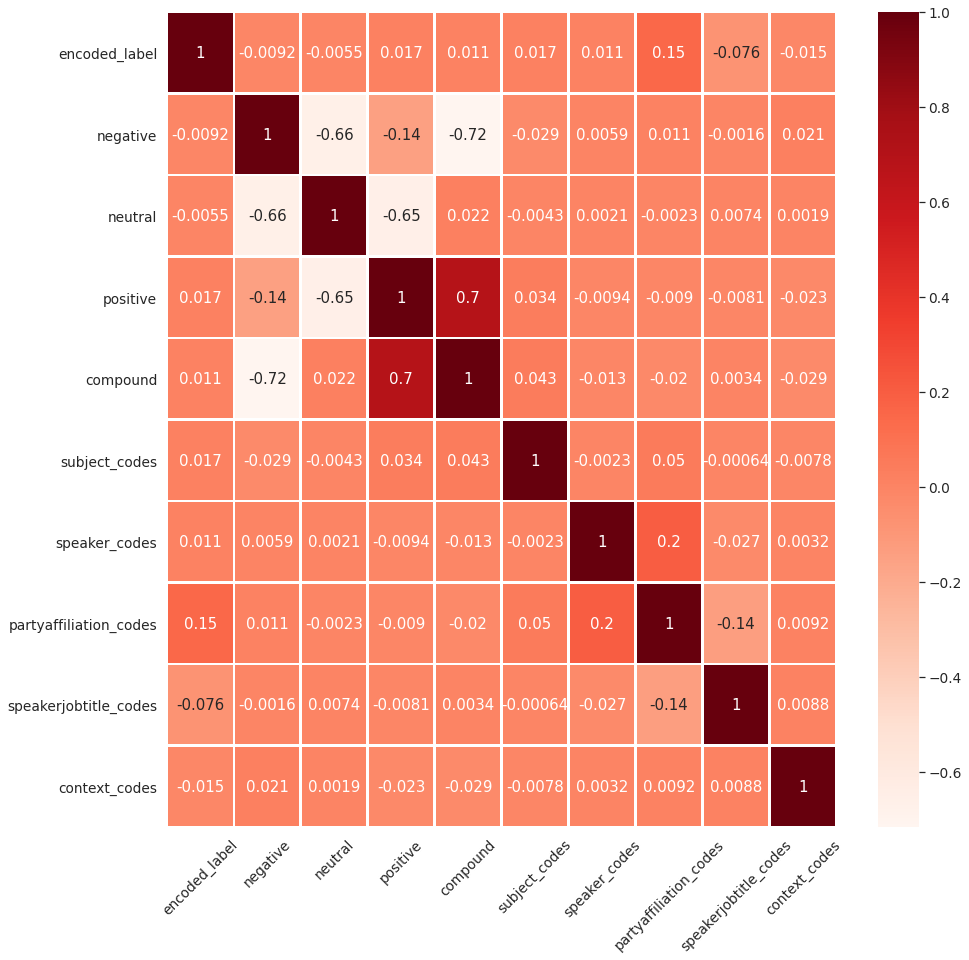

In [0]:
import matplotlib.pyplot as mp
figure, axes = mp.subplots(figsize=(15,15))
sns.heatmap(all_data.corr(), annot=True, vmax=1, linewidths=1.5, cmap='Reds')
mp.xticks(rotation=45)

## New Classification before LDA

### Test -Train

In [0]:
all_data.head(3)

,headline_text,processed_headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,context,encoded_label,tokenized,lda_topics,negative,neutral,positive,compound,subject_codes,speaker_codes,partyaffiliation_codes,speakerjobtitle_codes,context_codes
0,Says the Annies List political group supports ...,nanni list polit group support third trimest a...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,5,"[nanni, list, polit, group, support, third, tr...",trimest support nanni administr third polit li...,0.0,1.000,0.000,0.0000,31,868,20,930,1430
1,When did the decline of coal start? It started...,declin coal start start natur took start begin...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,3,"[declin, coal, start, start, natur, took, star...",trimest demand third polit administr support n...,0.0,0.794,0.206,0.0772,2810,2652,6,928,1257
2,"Hillary Clinton agrees with John McCain ""by vo...",hillari clinton agre john mccain vote give geo...,foreign-policy,barack-obama,President,Illinois,democrat,Denver,2,"[hillari, clinton, agr, john, mccain, vote, gi...",polit administr third trimest support nanni li...,0.0,0.597,0.403,0.4019,3139,197,6,686,87


In [0]:
#all_data = pd.concat([df_train[['processed_headline_text', 'encoded_label']], df_test[['processed_headline_text', 'encoded_label']]])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    all_data['processed_headline_text'], 
    all_data['encoded_label'], 
    random_state = 1
)

print("Training dataset: ", X_train.shape[0])
print("Test dataset: ", X_test.shape[0])

Training dataset:  8630
Test dataset:  2877


In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vector = CountVectorizer(stop_words = 'english')
training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

In [0]:
training_data.shape

(8630, 6598)

### Multinomial Naive Bias Classifiar

In [0]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Generate Prediction

In [0]:
predictions = naive_bayes.predict(testing_data)
predictions

array([3, 4, 2, ..., 1, 3, 5])

### Evaluate Model Performance

In [0]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print("Accuracy score: ", accuracy_score(y_test, predictions))
print("Recall score: ", recall_score(y_test, predictions, average = 'weighted'))
print("Precision score: ", precision_score(y_test, predictions, average = 'weighted'))
print("F1 score: ", f1_score(y_test, predictions, average = 'weighted'))

Accuracy score:  0.2599930483142162
Recall score:  0.2599930483142162
Precision score:  0.2618250606061912
F1 score:  0.2515737102825491


### AutoML

In [0]:
def get_words( headlines ):               
    headlines_onlyletters = re.sub("[^a-zA-Z]", " ",headlines) #Remove everything other than letters     
    words = headlines_onlyletters.lower().split() #Convert to lower case, split into individual words    
    stops = set(stopwords.words("english"))  #Convert the stopwords to a set for improvised performance                 
    meaningful_words = [w for w in words if not w in stops]   #Removing stopwords
    return( " ".join( meaningful_words )) #Joining the words
    

In [0]:

all_data['encoded_label'] = all_data['encoded_label'].astype('int')

In [0]:
def prepareTestTraining(x_col, y_col, articleDataFrame):
  #articleDataFrame['label_NewsCoverage'] = articleDataFrame['x_col'].astype('int')

  # Separate the dataframe for input(X) and output variables(y)
  #['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year','month', 'url', 'content', 'NYT summary', 'processed_content','score', 'label_NewsCoverage']
  X = articleDataFrame[x_col]
  Y = articleDataFrame[y_col]

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
  X_train = np.array(X_train);
  X_test = np.array(X_test);
  Y_train = np.array(Y_train);
  Y_test = np.array(Y_test);
  cleanHeadlines_train = [] #To append processed headlines
  cleanHeadlines_test = [] #To append processed headlines
  number_reviews_train = len(X_train) #Calculating the number of reviews
  number_reviews_test = len(X_test) #Calculating the number of reviews

  for i in range(0,number_reviews_train):
    cleanHeadline = get_words(X_train[i]) #Processing the data and getting words with no special characters, numbers or html tags
    cleanHeadlines_train.append( cleanHeadline )
  for i in range(0,number_reviews_test):
    cleanHeadline = get_words(X_test[i]) #Processing the data and getting words with no special characters, numbers or html tags
    cleanHeadlines_test.append( cleanHeadline )

  #vectorize = CountVectorizer(stop_words='english')
  vectorize = CountVectorizer(analyzer = "word",max_features = 1700)    #(stop_words='english')
  bagOfWords_train = vectorize.fit_transform(cleanHeadlines_train)
  X_train = bagOfWords_train.toarray()
  bagOfWords_test = vectorize.transform(cleanHeadlines_test)
  X_test = bagOfWords_test.toarray()

  #call autoML
  callAutoML(X_train,Y_train,X_test,Y_test)

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
num_folds = 10
seed = 7
scoring = 'accuracy'

models = []
models.append(('LR' , LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')))
models.append(('LDA' , LinearDiscriminantAnalysis()))
#models.append(('KNN' , KNeighborsClassifier()))
#models.append(('CART' , DecisionTreeClassifier()))
#models.append(('NB' , GaussianNB()))
#models.append(('SVM' , SVC()))
models.append(('MNB', MultinomialNB()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
#models.append(('XGBoost', XGBClassifier()))

In [0]:
def callAutoML(X_train,Y_train,X_test,Y_test):
  results = []
  names = []

  '''
  for name, model in models:
      kfold = KFold(n_splits=num_folds, random_state=42)
      cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      print(msg) '''

  for name, model in models:
      clf = model
      clf.fit(X_train, Y_train)
      Y_pred = clf.predict(X_test)
      accu_score = accuracy_score(Y_test, Y_pred)
      print(name + ": " + str(accu_score))

In [0]:
prepareTestTraining('processed_headline_text','encoded_label',all_data)

LR: 0.228786562409499
LDA: 0.22589052997393572
MNB: 0.23689545322907615
RF: 0.24181870836953373


### Pipeline

#### Naive Bayes

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
#from sklearn.linear_model import Logis

# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [0]:
# train the model using X_dtm & y
NB_pipeline.fit(X_train, y_train)
# compute the testing accuracy
prediction = NB_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))


Test accuracy is 0.2453945081682308


#### LinearSVC

In [0]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

In [0]:
SVC_pipeline.fit(X_train, y_train)
# compute the testing accuracy
prediction = SVC_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

Test accuracy is 0.24817518248175183


#### Logistic Regression

In [0]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

# train the model using X_dtm & y
LogReg_pipeline.fit(X_train, y_train)
# compute the testing accuracy
prediction = LogReg_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

Test accuracy is 0.25060827250608275


## New Classification after LDA

In [0]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection._search import BaseSearchCV
import pickle as pkl

seed = 58

# perform the split which gets us the train data and the test data
news_train, news_test, labels_train, labels_test = train_test_split(doc2vec_vectors3, labels,
                                                                    test_size=0.25,
                                                                    random_state=seed,
                                                                    stratify=labels)

In [0]:
import warnings
# Ignore some unimportant warnings
warnings.filterwarnings("ignore") 
                        
from mlxtend.classifier import EnsembleVoteClassifier

from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint
from scipy.stats.distributions import uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np



# KNN classifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
                           weights='distance')



# SVC classifier
svc = SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
          max_iter=-1, probability=True, random_state=0, shrinking=True,
          tol=0.001, verbose=False)

# GNB classifier
gnb = GaussianNB(priors=None)

# RF classifier
rf = RandomForestClassifier(bootstrap=False, class_weight=None,
                            criterion='entropy', max_depth=10, max_features=7,
                            max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, min_samples_leaf=9,
                            min_samples_split=6, min_weight_fraction_leaf=0.0,
                            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
                            verbose=0, warm_start=False)

# LG classifier
lg = LogisticRegression(C=7.374558791, class_weight=None, dual=False,
                        fit_intercept=True, intercept_scaling=1, max_iter=100,
                        multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                        solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

#mnb = MultinomialNB()

classifiers_list = [knn,  svc, gnb, rf, lg]
model_names = ['knn',  'svc', 'gnb', 'rf', 'lg']

In [0]:
from sklearn.metrics import classification_report

# print details of testing results
i = 0
for model in classifiers_list:
    model.fit(news_train, labels_train)
    labels_pred = model.predict(news_test)
    
    # Report the metrics
    target_names = ['true','mostly-true','half-true','barely-true','false','pants-fire']
    print(model.__class__.__name__)
    print('Test accuracy is {}'.format(accuracy_score(labels_test, labels_pred)))
    #print(classification_report(y_true=labels_test, y_pred=labels_pred, target_names=target_names, digits=3))
    #filename = model_names[i]+'.pkl'
    #pkl.dump(model, open(filename, 'wb'))
    i+=1

KNeighborsClassifier
Test accuracy is 0.20264164059784498
SVC
Test accuracy is 0.20924574209245742
GaussianNB
Test accuracy is 0.22384428223844283
RandomForestClassifier
Test accuracy is 0.23531456378171706
LogisticRegression
Test accuracy is 0.2283628779979145


# Reference

* 1. https://github.com/susanli2016/Machine-Learning-with-Python
* 2. https://www.kaggle.com/cnokello/news-article-classification-using-naive-bayes
* 3. https://www.kaggle.com/ngyptr/multi-class-classification-with-lstm